In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ktrain==0.32.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 69.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 56.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 65.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.32.3-py3-no

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import ktrain
from ktrain import text
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Import necessary libraries
import nltk
nltk.download('punkt')  
from nltk.stem import PorterStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Import necessary libraries
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [6]:
# Load the train and test datasets
testpath = '/content/drive/MyDrive/archive (20)/test.csv'
trainingpath = '/content/drive/MyDrive/archive (20)/train.csv'
train = pd.read_csv(trainingpath)
test = pd.read_csv(testpath)

In [7]:
# Define the clean_text function to preprocess the text data
def clean_text(text):
    stemmer = PorterStemmer()  # Initialize the PorterStemmer object
    text = str(text).lower()  # Convert text to lowercase
    text = re.sub('\d+', '', text)  # Remove all numbers from the text
    text = re.sub('\[.*?\]', '', text)  # Remove HTML tags from the text
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs from the text
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove all punctuation marks from the text
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Stemming and stopwords removal
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(stemmed_tokens)

In [8]:
# Encode the labels
label_encoder = LabelEncoder()
train['Class Index'] = label_encoder.fit_transform(train['Class Index'])
test['Class Index'] = label_encoder.transform(test['Class Index'])

In [9]:
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
# Define a function to encode texts into a format suitable for the model training
def encode_texts(tokenizer, texts, max_len=256):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
        )
        # Ensure the tensors are squeezed to remove unnecessary dimensions
        input_ids.append(tf.squeeze(encoded['input_ids']))
        attention_masks.append(tf.squeeze(encoded['attention_mask']))
    return np.array(input_ids), np.array(attention_masks)

In [11]:
# Encode the text data
X_train_ids, X_train_masks = encode_texts(tokenizer, train['Description'].values, max_len=512)
X_test_ids, X_test_masks = encode_texts(tokenizer, test['Description'].values, max_len=512)

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
# Convert labels to one-hot encoding
y_train = to_categorical(train['Class Index'].values)
y_test = to_categorical(test['Class Index'].values)

In [13]:
# Load the DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [14]:
# Prepare the model for training
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [16]:
# Training the model
model.fit([X_train_ids, X_train_masks], y_train, epochs=1, batch_size=28,
          validation_data=([X_test_ids, X_test_masks], y_test))

4286/4286 [==============================] - 6598s 2s/step - loss: 0.2337 - accuracy: 0.9198 - val_loss: 0.1981 - val_accuracy: 0.9351


238/238 [==============================] - 154s 625ms/step


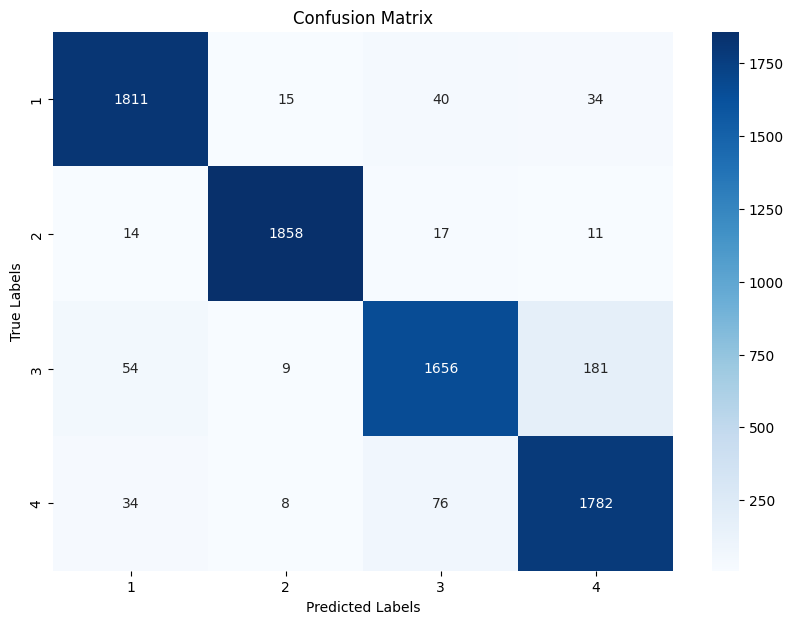

In [17]:
# Predict on the test data
test_pred_logits = model.predict([X_test_ids, X_test_masks])
test_pred = tf.argmax(test_pred_logits.logits, axis=1)

# Convert one-hot encoded test labels back to class indices for comparison
y_test_labels = tf.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Convert numeric class indices to strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Generate the classification report
cr = classification_report(y_test_labels, test_pred, target_names=target_names)
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.95      0.95      1900
           2       0.98      0.98      0.98      1900
           3       0.93      0.87      0.90      1900
           4       0.89      0.94      0.91      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



In [19]:
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

#evaluate the model on the test set

# Sample 30 random descriptions from the test set
random_indices = random.sample(range(test.shape[0]), 30)
sample_test = test.iloc[random_indices]

# Encode the samples
sample_test_ids, sample_test_masks = encode_texts(tokenizer, sample_test['Description'].values, max_len=256)

# Predict on these samples
sample_test_pred_logits = model.predict([sample_test_ids, sample_test_masks])
sample_test_pred = tf.argmax(sample_test_pred_logits.logits, axis=1)

# Extract the true labels
sample_test_true_labels = tf.argmax(to_categorical(sample_test['Class Index'].values), axis=1)

# Convert predictions and true labels to original category
predictions = label_encoder.inverse_transform(sample_test_pred.numpy())
true_labels = label_encoder.inverse_transform(sample_test_true_labels.numpy())

# Print the comparison
for i, description in enumerate(sample_test['Description']):
    print(f"Description: {description}")
    print(f"Predicted Category: {predictions[i]}")
    print(f"True Category: {true_labels[i]}\n")
    
#the numeric labels refers to ------->  1-World, 2-Sports, 3-Business, 4-Sci/Tech 

1/1 [==============================] - 2s 2s/step
Description: IBM, Sony Corp. and Toshiba Corp. on Monday unveiled some key details on the powerful new  quot;Cell quot; processor the three are jointly producing to run next-generation computers, game consoles and TVs.
Predicted Category: 4
True Category: 4

Description: Australia wrapped up a 2-0 win in the series after beating New Zealand by 213 runs on the fifth day of the second and final cricket Test on Tuesday.
Predicted Category: 2
True Category: 2

Description:  MILAN (Reuters) - Citigroup on Friday launched a legal  challenge against a restructuring plan drawn up by Parmalat,  hitting back after the bankrupt food group took the world's  biggest bank to court recently.
Predicted Category: 3
True Category: 3

Description: CHICAGO - Hewlett-Packard(HP) has moved its Active Counter Measures network security software into beta tests with a select group of European and North American customers in hopes of readying the product for a 2